In [1]:
!pip install ISLP -q
!pip install great_tables
!pip install stargazer

In [158]:
import numpy as np
import pandas as pd
from great_tables import GT as GT
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from stargazer.stargazer import Stargazer

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import ModelSpec as MS
from functools import partial
import networkx as nx

import os

from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.grf import CausalIVForest
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso

import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_stata('./replication_sample.dta')
df_main = df[df['main_sample']==1]
df_main_adj = df_main.drop(columns=['negative_HHIchange','timetoswitch', 'diffr_hat'])

#change if you want negative_HHIchange and timetoswitch included
df_main = df_main_adj
df_main = df_main.astype('float32')

df_main = df_main.dropna()

df_main.columns
print(df_main.shape)

(52476, 29)


# Set-Up

In [4]:
design = MS(df_main.columns.drop(['allP_sample','main_sample','ind_sample','constant', 'logr_hat', 'logr_bar', 
                                 'r_hat', 'HHI_bar', 'shiftmerge', 'sapientmerge', 'merklemerge', 'forsmanmerge'])).fit(df_main)
Y = np.array(df_main['logr_hat'])
R = design.fit_transform(df_main)
D = R.drop('intercept', axis=1)
X = np.asarray(D)

Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]

print(D)
print(X)

df_main.head()

          year  newhclust   HHI_hat  num_words   num_char  long_tail  \
61      2015.0   100302.0  0.250000   1.666667  12.666667   0.000000   
62      2016.0   100302.0  0.250000   1.714286  10.142858   0.142857   
63      2017.0   100302.0  0.500016   1.500000   9.000000   0.000000   
66      2016.0   100303.0  1.000000   1.800000  13.000000   0.000000   
69      2015.0   100304.0  1.000000   2.200000  14.000000   0.000000   
...        ...        ...       ...        ...        ...        ...   
221399  2016.0  2299907.0  0.186252   5.000000  31.000000   1.000000   
221402  2016.0  2299908.0  0.169746   4.000000  22.000000   1.000000   
221403  2017.0  2299908.0  0.075408   4.000000  22.000000   1.000000   
221406  2016.0  2299909.0  0.180000   3.000000  18.000000   0.000000   
221411  2017.0  2299910.0  0.200000   6.000000  36.000000   1.000000   

         branded  numind  numberofresults    logcpc     logvol    lognum  sim  \
61      0.000000     1.0         0.001094  0.602493   

,year,newhclust,HHI_bar,HHI_hat,r_hat,num_words,num_char,long_tail,branded,numind,...,evermerged,allP_sample,main_sample,ind_sample,own_branded,other_branded,shiftmerge,sapientmerge,merklemerge,forsmanmerge
61,2015.0,100302.0,0.25,0.250000,67775.187500,1.666667,12.666667,0.000000,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
62,2016.0,100302.0,0.25,0.250000,166625.484375,1.714286,10.142858,0.142857,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
63,2017.0,100302.0,0.50,0.500016,82004.382812,1.500000,9.000000,0.000000,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
66,2016.0,100303.0,1.00,1.000000,26974.587891,1.800000,13.000000,0.000000,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
69,2015.0,100304.0,1.00,1.000000,14800.043945,2.200000,14.000000,0.000000,0.2,1.0,...,0.0,1.0,1.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0


# IV Forest - Long-tailed

In [1126]:
# Prepare data
Y = df_main[['logr_hat']].values
T = df_main[['HHI_hat']].values
scaler = StandardScaler()
Z = df_main[['sim']].values
#W1 = scaler.fit_transform([['num_words', 'num_char']].values)
#W2 = pd.get_dummies(oj_data[['brand']]).values
#W = np.concatenate([W1, W2], axis=1)
X = df_main[['long_tail']].values

In [1128]:
# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

In [1130]:
est = CausalIVForest(criterion='mse', n_estimators=400, min_samples_leaf=40,
                     min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
                     min_impurity_decrease = 0.001, max_samples=.45, max_depth=None,
                     warm_start=False, inference=True, subforest_size=4,
                     honest=True, verbose=0, n_jobs=-1, random_state=123)

In [1132]:
est.fit(X, T, y=Y, Z=Z)

CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
               n_estimators=400, random_state=123)

In [1133]:
min_long_tail = 0.0
max_long_tail = 1.0
delta = (max_long_tail - min_long_tail) / 10
X_test = np.arange(min_long_tail, max_long_tail, delta).reshape(-1, 1)

In [1136]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

Text(0.5, 1.0, 'Revenue Effect of HHI by Long-tailed Keywords: IVCausalForest')

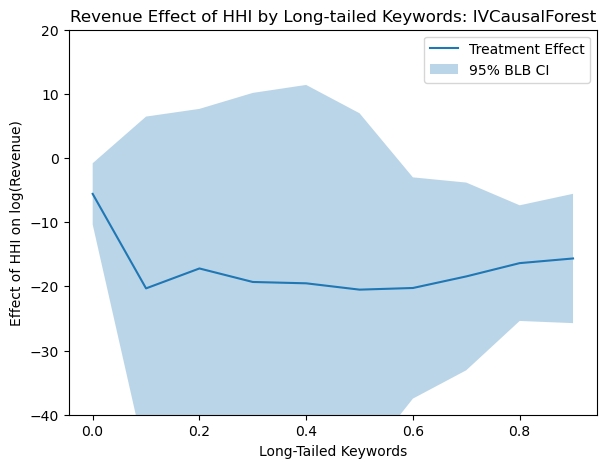

In [1138]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test.flatten(), point, label="Treatment Effect")
plt.fill_between(X_test.flatten(), lb.flatten(), ub.flatten(), label="95% BLB CI", alpha=0.3)
plt.xlabel('Long-Tailed Keywords')
plt.ylabel('Effect of HHI on log(Revenue)')
ax = plt.gca()
ax.set_ylim([-40, 20])
plt.legend()
plt.title("Revenue Effect of HHI by Long-tailed Keywords: IVCausalForest")

In [858]:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got GRFTree(max_features='auto', min_impurity_decrease=0.001, min_samples_leaf=40,
        min_var_leaf=3.543850152940905e-05, min_var_leaf_on_val=True,
        random_state=914636141) instead.

<Figure size 2000x1000 with 0 Axes>

In [860]:
X = df_main[['own_branded']].values

In [862]:
est.fit(X, T, y=Y, Z=Z)

CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
               n_estimators=400, random_state=123)

In [864]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

Text(0.5, 1.0, 'Revenue Effect of HHI by Own-Branded Bidding: IVCausalForest')

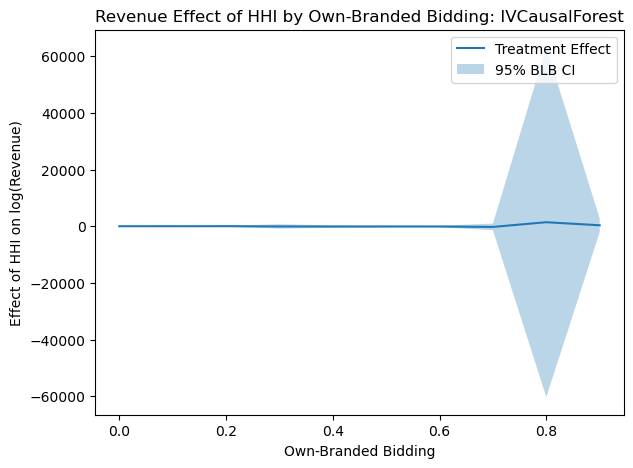

In [866]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test.flatten(), point, label="Treatment Effect")
plt.fill_between(X_test.flatten(), lb.flatten(), ub.flatten(), label="95% BLB CI", alpha=0.3)
plt.xlabel('Own-Branded Bidding')
plt.ylabel('Effect of HHI on log(Revenue)')
#ax = plt.gca()
#ax.set_ylim([-40, 20])
plt.legend()
plt.title("Revenue Effect of HHI by Own-Branded Bidding: IVCausalForest")

In [972]:
X = df_main[['year']].values

In [974]:
est.fit(X, T, y=Y, Z=Z)

CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
               n_estimators=400, random_state=123)

In [975]:
X_test = np.array([2015, 2016, 2017])
X_test = X_test.reshape(-1, 1)

In [978]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

Text(0.5, 1.0, 'Revenue Effect of HHI by Year: IVCausalForest')

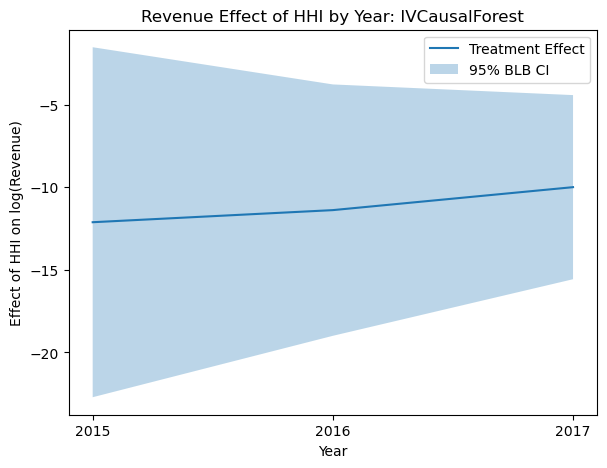

In [980]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test.flatten(), point, label="Treatment Effect")
plt.fill_between(X_test.flatten(), lb.flatten(), ub.flatten(), label="95% BLB CI", alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Effect of HHI on log(Revenue)')
plt.xticks([2015, 2016, 2017])
#ax = plt.gca()
#ax.set_ylim([-40, 20])
plt.legend()
plt.title("Revenue Effect of HHI by Year: IVCausalForest")

TypeError: only length-1 arrays can be converted to Python scalars

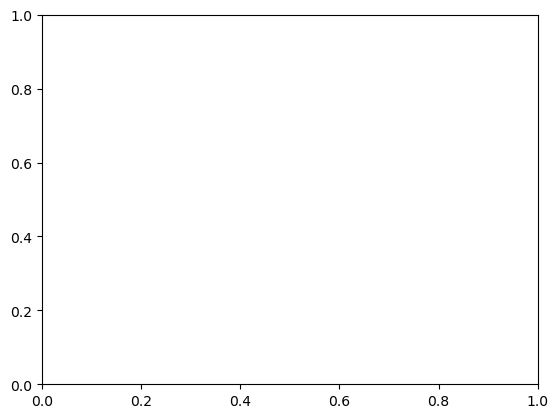

In [1032]:
X_test = [2015, 2016, 2017]
up_err = np.array([1.52, 3.78, 4.42])  # Upper error bounds
down_err = np.array([22.71, 18.99, 15.56])  # Lower error bounds

# Calculate the total y-error
yerror = [down_err, up_err]  # Tuple of lower and upper errors for error bars

# Create the bar chart
plt.bar(X_test, point, color="skyblue", label="Point estimate")

# Add error bars
plt.errorbar(X_test, point, yerr=yerror, fmt="o", color="red", label="Error bars", capsize=5)

# Formatting
plt.xticks(X_test)
plt.xlabel('Year')
plt.ylabel('Effect of HHI on log(Revenue)')
plt.legend()
plt.title('Effect of HHI on Revenue with Error Bars')

# Display the plot
plt.show()

In [1034]:
yerror

[array([22.71, 18.99, 15.56]), array([1.52, 3.78, 4.42])]

In [932]:
X = df_main[['other_branded']].values

In [934]:
est.fit(X, T, y=Y, Z=Z)

CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
               n_estimators=400, random_state=123)

In [936]:
min_otherb = 0.0
max_otherb = 1.0
delta = (max_otherb - min_otherb) / 10
X_test = np.arange(min_otherb, max_otherb, delta).reshape(-1, 1)

In [938]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

Text(0.5, 1.0, 'Revenue Effect of HHI by Other-Branded Bidding: IVCausalForest')

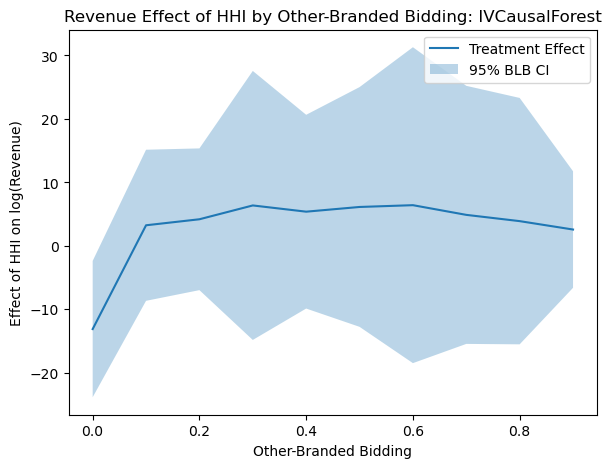

In [940]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test.flatten(), point, label="Treatment Effect")
plt.fill_between(X_test.flatten(), lb.flatten(), ub.flatten(), label="95% BLB CI", alpha=0.3)
plt.xlabel('Other-Branded Bidding')
plt.ylabel('Effect of HHI on log(Revenue)')
#ax = plt.gca()
#ax.set_ylim([-40, 20])
plt.legend()
plt.title("Revenue Effect of HHI by Other-Branded Bidding: IVCausalForest")

In [942]:
X = df_main[['branded']].values

In [944]:
est.fit(X, T, y=Y, Z=Z)

CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
               n_estimators=400, random_state=123)

In [946]:
min_branded = 0.0
max_branded = 1.0
delta = (max_branded - min_branded) / 10
X_test = np.arange(min_branded, max_branded, delta).reshape(-1, 1)

In [948]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

Text(0.5, 1.0, 'Revenue Effect of HHI by Branded Keywords: IVCausalForest')

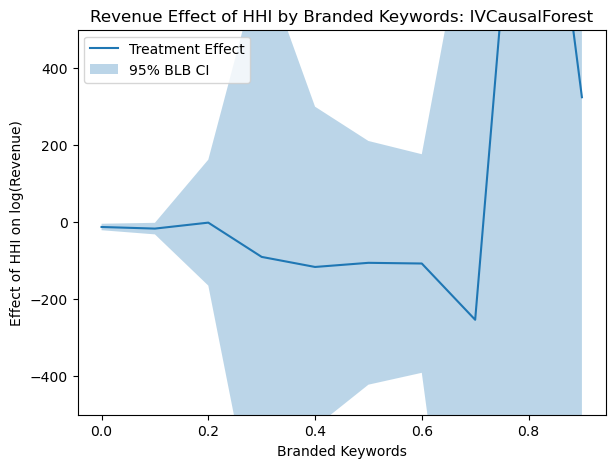

In [950]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test.flatten(), point, label="Treatment Effect")
plt.fill_between(X_test.flatten(), lb.flatten(), ub.flatten(), label="95% BLB CI", alpha=0.3)
plt.xlabel('Branded Keywords')
plt.ylabel('Effect of HHI on log(Revenue)')
ax = plt.gca()
ax.set_ylim([-500, 500])
plt.legend()
plt.title("Revenue Effect of HHI by Branded Keywords: IVCausalForest")

In [952]:
X = df_main[['numberofresults']].values

In [954]:
est.fit(X, T, y=Y, Z=Z)

CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
               n_estimators=400, random_state=123)

In [1046]:
min_results = 0.0
max_results = 1
delta = (max_results - min_results) / 10
X_test = np.arange(min_results, max_results, delta).reshape(-1, 1)

In [958]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

Text(0.5, 1.0, 'Revenue Effect of HHI by Number of Search Results: IVCausalForest')

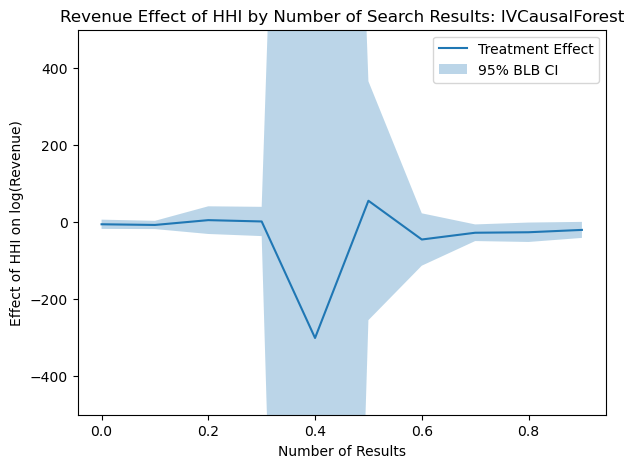

In [960]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test.flatten(), point, label="Treatment Effect")
plt.fill_between(X_test.flatten(), lb.flatten(), ub.flatten(), label="95% BLB CI", alpha=0.3)
plt.xlabel('Number of Results')
plt.ylabel('Effect of HHI on log(Revenue)')
ax = plt.gca()
ax.set_ylim([-500, 500])
plt.legend()
plt.title("Revenue Effect of HHI by Number of Search Results: IVCausalForest")

In [1052]:
X = df_main[['HHI_hat']].values

In [1054]:
est.fit(X, T, y=Y, Z=Z)

CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
               n_estimators=400, random_state=123)

In [1090]:
min_HHI = 0.0
max_HHI = 1
delta = (max_HHI - min_HHI) / 10
X_test = np.arange(min_HHI, max_HHI, delta).reshape(-1, 1)

In [1092]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

Text(0.5, 1.0, 'Revenue Effect of HHI by HHI Level: IVCausalForest')

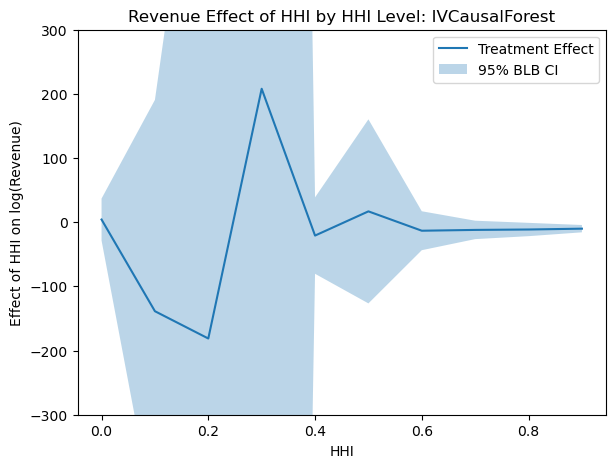

In [1098]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test.flatten(), point, label="Treatment Effect")
plt.fill_between(X_test.flatten(), lb.flatten(), ub.flatten(), label="95% BLB CI", alpha=0.3)
plt.xlabel('HHI')
plt.ylabel('Effect of HHI on log(Revenue)')
ax = plt.gca()
ax.set_ylim([-300, 300])
plt.legend()
plt.title("Revenue Effect of HHI by HHI Level: IVCausalForest")

# Long-Tailed HTE

In [121]:
# Prepare data
Y = df_main[['logr_hat']].values
T = df_mfain[['HHI_hat']].values
scaler = StandardScaler()
W = df_main[['sim']].values
#W1 = scaler.fit_transform(oj_data[[c for c in df_main.columns
                                   #if c not in ['price', 'logmove', 'brand', 'week', 'store']]].values)
#W2 = pd.get_dummies(oj_data[['brand']]).values
#W = np.concatenate([W1, W2], axis=1)
X = df_main[['long_tail']].values

In [123]:
# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

In [125]:
est = DMLOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth,
        subsample_ratio=subsample_ratio,
        model_T=Lasso(alpha=0.1),
        model_Y=Lasso(alpha=0.1),
        model_T_final=WeightedLassoCVWrapper(cv=3),
        model_Y_final=WeightedLassoCVWrapper(cv=3)
       )

In [127]:
est.fit(Y, T, X=X, W=W)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.7s finished


In [225]:
min_long_tail = 0.0
max_long_tail = 1.0
delta = (max_long_tail - min_long_tail) / 100
X_test = np.arange(min_long_tail, max_long_tail, delta).reshape(-1, 1)

In [131]:
# Calculate marginal treatment effects
treatment_effects = est.const_marginal_effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.9s finished


In [133]:
# Calculate default (95%) marginal confidence intervals for the test data
te_upper, te_lower = est.const_marginal_effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


In [135]:
est2 = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3),
                       model_t=WeightedLassoCVWrapper(cv=3),
                       n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                       max_samples=subsample_ratio/2,
                       random_state=123)
est2.fit(Y, T, X=X)
treatment_effects2 = est2.effect(X_test)
te_lower2, te_upper2 = est2.effect_interval(X_test)

Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x3168516d0> has a non-default cv attribute, which will be ignored
Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x316853fe0> has a non-default cv attribute, which will be ignored


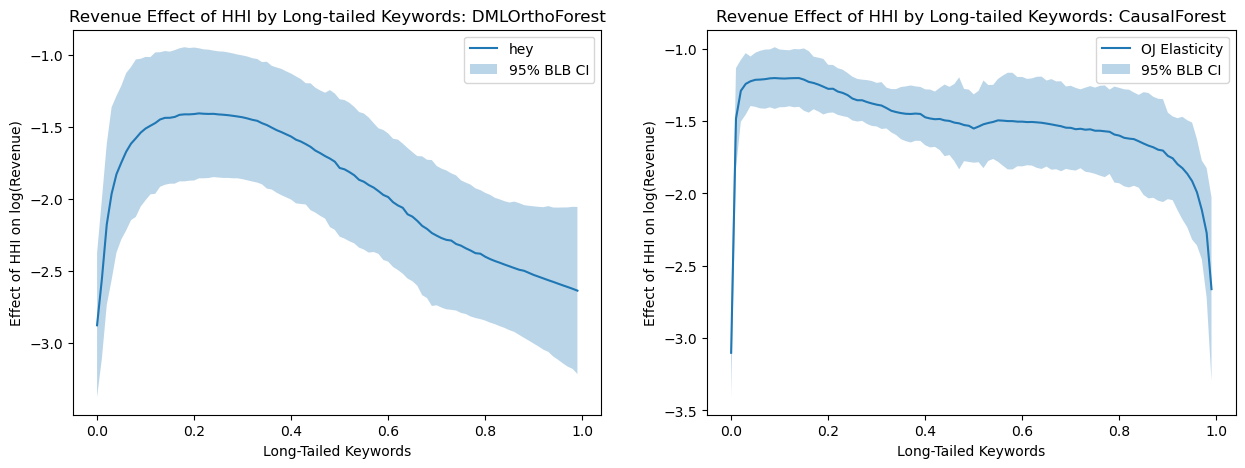

In [141]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test.flatten(), treatment_effects.flatten(), label="hey")
plt.fill_between(X_test.flatten(), te_lower.flatten(), te_upper.flatten(), label="95% BLB CI", alpha=0.3)
plt.xlabel('Long-Tailed Keywords')
plt.ylabel('Effect of HHI on log(Revenue)')
plt.legend()
plt.title("Revenue Effect of HHI by Long-tailed Keywords: DMLOrthoForest")
plt.subplot(1, 2, 2)
plt.plot(X_test.flatten(), treatment_effects2.flatten(), label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_lower2.flatten(), te_upper2.flatten(), label="95% BLB CI", alpha=0.3)
plt.xlabel('Long-Tailed Keywords')
plt.ylabel('Effect of HHI on log(Revenue)')
plt.legend()
plt.title("Revenue Effect of HHI by Long-tailed Keywords: CausalForest")
plt.show()

(array([ 1.,  5., 13., 10.,  8.,  5.,  8.,  9., 10., 31.]),
 array([-2.87549479, -2.72831504, -2.58113529, -2.43395554, -2.28677579,
        -2.13959603, -1.99241628, -1.84523653, -1.69805678, -1.55087703,
        -1.40369728]),
 <BarContainer object of 10 artists>)

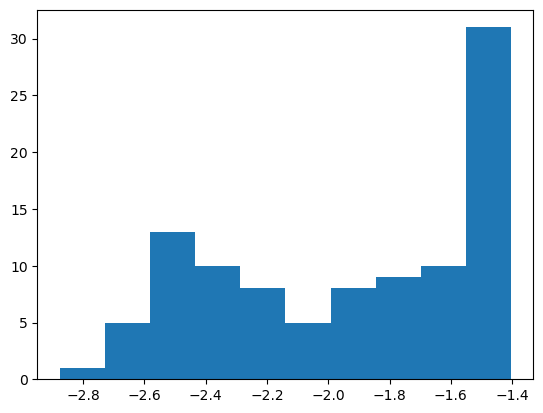

In [155]:
plt.hist(treatment_effects.flatten())

In [ ]:
from econml.grf import CausalForest

yres = 